# 实战案例：基于多模态因子双线性池化（MFB）的视觉问答
:label:`sec_visual-question-answering-mfb`

## 视觉问答技术简介

视觉问答的关键是挖掘图像和问题之间的关联，并融合二者推理出答案。形式上，视觉问答模型需要融合图像和文本两个模态的输入信息，预测出文本模态形式的答案或答案对应的类别编号。

现有的视觉问答技术可以被细分为四类：一是基于特征融合的方法，即利用线性融合或者双线性融合方法综合图像和问题的信息；二是基于注意力的方法，即利用注意力机制将图像中的区域和问题进行多模态对齐和融合；三是基于视觉关系建模的方法，该方法显示的建模图像中区域间的关系，并利用多模态对齐技术建立这些关系和问题的联系，最终利用多模态融合技术综合关系和问题；四是基于模块网络的方法，其首先利用全连接层、卷积层、注意力层等单元预定义一系列模块，包括属性或实体查找模块、关注区域转换模块、组合模块、属性描述模块、计数模块等，然后将问题解析为可以和这些模块对应的部分，最后依据对问题的解析结果动态的组装预定义的模块。

需要说明的是，这四类方法并非完全独立，例如使用这四类方法构建视觉问答模型时，大多都会使用注意力机制进行多模态融合和对齐。

![基于多模态因子双线性池化和注意力的视觉问答模型框架示意图](../img/mf-mfbvqa-framework.png)
:label:`fig_mf-mfbvqa-framework`

本节，我们将具体介绍一个基于多模态因子双线性池化 (Multimodal Factorized Bilinear, MFB) :cite:`Yu.Yu.Fa.ea.2017` 和注意力的视觉问答模型（MFBVQA模型）的实战案例。如 :numref:`fig_mf-mfbvqa-framework` 所示，该模型首先利用注意力将问题和图像中的区域进行多模态对齐，其中注意力评分函数为MFB，然后再次利用MFB融合多模态对齐前后的问题表示，最终推理出答案。

下面，我们将按照读取数据、定义模型、定义损失函数、选择优化方法、选择评估指标和训练模型的顺序，依次介绍该模型的具体实现。

## 读取数据
:label:`sec_mfb-read-dataset`

### 下载数据集
:label:`sec_mfb-download-dataset`

我们使用的数据集为VQA v2([下载地址](https://visualqa.org/download.html))。该数据集中的图像来自于MS COCO，我们需要下载[bottom up attention模型](https://github.com/peteanderson80/bottom-up-attention)提供的[图像区域表示](https://storage.googleapis.com/up-down-attention/trainval_36.zip)。该文件解压后的tsv文件包含了MS COCO训练集和验证集中所有图片的36个检测框的视觉表示。本节的代码将tsv文件放在目录../data/vqa/coco下。

对于问题和回答，我们需要下载四个文件：训练标注集（训练回答集）、验证标注集（训练回答集）、训练问题集和验证问题集。将这四个文件解压后，我们得到4个json格式的文件，并将其放在指定目录(本节的代码中将该目录设置为../data/vqa)下的vqa2文件夹里。由于测试集的标注集未公开，因此这里仅下载训练集和验证集。下载的数据集包含443,757个训练问题和214,354个验证问题，每个问题对应10个人工标注的答案。

### 整理数据集

数据集下载完成后，我们需要对其进行处理，以适合之后构造的PyTorch数据集类读取。
对于图像，我们按照 :numref:`sec_scan-bua-extraction` 介绍的方式，将每张图片的36个检测框表示存储为单个npy格式文件，并将文件路径记录在数据json文件中。为了后续的数据分析，我们还将检测框的位置信息也以npy格式存储。json文件中的路径仅存储文件名前缀，加上后缀'.npy'为图像特征，加上后缀'.box.npy'为检测框特征。

In [1]:
import base64
import csv
import json
import numpy as np
import os
from os.path import join as pjoin
import sys

csv.field_size_limit(sys.maxsize)

def resort_image_feature():
    image_feature_path = '../data/vqa/coco/trainval_resnet101_faster_rcnn_genome_36.tsv' 
    feature_folder = '../data/vqa/coco/image_box_features'
    if not os.path.exists(feature_folder):
        os.makedirs(feature_folder)
        
    imgid2feature = {}
    imgid2box = {}
    FIELDNAMES = ['image_id', 'image_h', 'image_w', 'num_boxes', 'boxes', 'features']
    with open(image_feature_path, 'r') as tsv_in_file:
        reader = csv.DictReader(tsv_in_file, delimiter='\t', fieldnames = FIELDNAMES)
        for item in reader:
            item['num_boxes'] = int(item['num_boxes'])
            for field in ['boxes', 'features']:
                buf = base64.b64decode(item[field])
                temp = np.frombuffer(buf, dtype=np.float32)
                item[field] = temp.reshape((item['num_boxes'],-1))
            np.save(pjoin(feature_folder, item['image_id']+'.jpg.npy'), item['features'])
            np.save(pjoin(feature_folder, item['image_id']+'.jpg.box.npy'), item['boxes'])

# resort_image_feature()

对于回答，我们取出现频次最高的max_ans_count个回答，将任务转化为max_ans_count个类的分类任务，并将每个问题的多个回答转化为列表。

对于问题，我们首先构建词典，然后根据词典将问题转化为向量，并过滤掉所有回答都不在高频回答中的问题样本，

In [2]:
from collections import defaultdict, Counter
import json
import os
from os.path import join as pjoin
import random 
import re
import torch
from PIL import Image

def tokenize_mcb(s):
    """
    问题词元化（tokenization）函数，来源于https://github.com/Cadene/block.bootstrap.pytorch/blob/master/block/datasets/vqa_utils.py
    """
    t_str = s.lower()
    for i in [r'\?',r'\!',r'\'',r'\"',r'\$',r'\:',r'\@',r'\(',r'\)',r'\,',r'\.',r'\;']:
        t_str = re.sub( i, '', t_str)
    for i in [r'\-',r'\/']:
        t_str = re.sub( i, ' ', t_str)
    q_list = re.sub(r'\?','',t_str.lower()).split(' ')
    q_list = list(filter(lambda x: len(x) > 0, q_list))
    return q_list

def tokenize_questions(questions):
    for item in questions:
        item['question_tokens'] = tokenize_mcb(item['question'])
    return questions

def annotations_in_top_answers(annotations, questions, ans_vocab):
    new_anno = []
    new_ques = []
    assert len(annotations) == len(questions)
    for anno,ques in zip(annotations, questions):
        if anno['multiple_choice_answer'] in ans_vocab:
            new_anno.append(anno)
            new_ques.append(ques)
    return new_anno, new_ques
    
def encode_questions(questions, vocab):
    for item in questions:
        item['question_idx'] = [vocab.get(w, vocab['<unk>']) for w in item['question_tokens']]
    return questions

def encode_answers(annotations, vocab):
    # 记录回答的频率
    for item in annotations:
        item['answer_list'] = []
        answers = [a['answer'] for a in item['answers']]
        for ans in answers:
            if ans in vocab:
                item['answer_list'].append(vocab[ans])
    return annotations

def create_dataset(dataset='flickr8k',
                   max_ans_count=1000, 
                   min_word_count=10):
    """
    参数：
        dataset：数据集名称
        max_ans_count：取训练集中最高频的1000个答案
        min_word_count：仅考虑在训练集中问题文本里出现10次及以上的词
    输出：
        一个词典文件： vocab.json
        两个数据集文件： train_data.json、 val_data.json
    """
    dir_vqa2 = '../data/vqa/vqa2'
    dir_processed = os.path.join(dir_vqa2, 'processed')
    dir_ann = pjoin(dir_vqa2, 'raw', 'annotations')
    path_train_ann = pjoin(dir_ann, 'mscoco_train2014_annotations.json')
    path_train_ques = pjoin(dir_ann, 'OpenEnded_mscoco_train2014_questions.json')
    path_val_ann = pjoin(dir_ann, 'mscoco_val2014_annotations.json')
    path_val_ques = pjoin(dir_ann, 'OpenEnded_mscoco_val2014_questions.json')

    # 读取回答和问题
    train_anno = json.load(open(path_train_ann))['annotations']
    train_ques = json.load(open(path_train_ques))['questions']
    
    val_anno = json.load(open(path_val_ann))['annotations']
    val_ques = json.load(open(path_val_ques))['questions']
    
    # 取出现频次最高的nans个回答，将任务转化为nans个类的分类问题
    ans2ct = defaultdict(int)
    for item in train_anno:
        ans = item['multiple_choice_answer'] 
        ans2ct[ans] += 1
    ans_ct = sorted(ans2ct.items(), key=lambda item:item[1], reverse=True)
    ans_vocab = [ans_ct[i][0] for i in range(max_ans_count)] 
    ans_vocab = {a:i for i,a in enumerate(ans_vocab)}
    train_anno = encode_answers(train_anno, ans_vocab)
    val_anno = encode_answers(val_anno, ans_vocab)
    # 处理问题文本
    train_ques = tokenize_questions(train_ques)
    val_ques = tokenize_questions(val_ques)
    # 保留高频词
    ques_vocab = Counter()
    for item in train_ques:
        ques_vocab.update(item['question_tokens'])
    ques_vocab = [w for w in ques_vocab.keys() if ques_vocab[w] > min_word_count]
    ques_vocab = {q:i for i,q in enumerate(ques_vocab)}
    ques_vocab['<unk>'] = len(ques_vocab)
    train_ques = encode_questions(train_ques, ques_vocab)
    val_ques = encode_questions(val_ques, ques_vocab)
    # 过滤掉所有回答都不在高频回答中的数据
    train_anno, train_ques = annotations_in_top_answers(
            train_anno, train_ques, ans_vocab)

    if not os.path.exists(dir_processed):
        os.makedirs(dir_processed)
    # 存储问题和回答词典
    with open(pjoin(dir_processed, 'vocab.json'), 'w') as fw:
        json.dump({'ans_vocab': ans_vocab, 'ques_vocab': ques_vocab}, fw)
    # 存储数据
    with open(pjoin(dir_processed, 'train_data.json'), 'w') as fw:
        json.dump({'annotations':train_anno, 'questions':train_ques}, fw)
    with open(pjoin(dir_processed, 'val_data.json'), 'w') as fw:
        json.dump({'annotations':val_anno, 'questions':val_ques}, fw)
    
# create_dataset()

在调用该函数生成需要的格式的数据集文件之后，我们可以展示其中一条数据，简单验证下数据的格式是否和我们预想的一致。

COCO_val2014_000000398525.jpg
question:  is there a garbage can in the picture
answer:  yes/yes/yes/yes/yes/yes/yes/yes/yes/yes


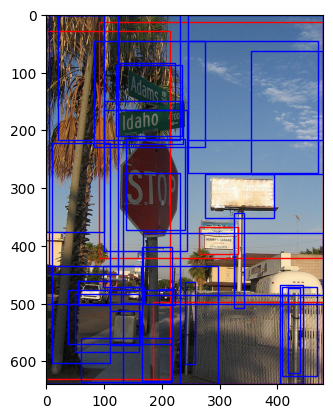

In [2]:
%matplotlib inline
import json
from matplotlib import pyplot as plt
import numpy as np
from os.path import join as pjoin
from PIL import Image

data_dir = '../data/vqa/vqa2/'
dir_processed = pjoin(data_dir, 'processed')
rcnn_dir='../data/vqa/coco/image_box_features/'
image_dir = '../data/vqa/coco/raw/val2014/'

vocab = json.load(open(pjoin(dir_processed, 'vocab.json'), 'r'))
dataset = json.load(open(pjoin(dir_processed, 'val_data.json'), 'r'))

idx2ans = {i:a for a,i in vocab['ans_vocab'].items()}
idx2ques = {i:q for q,i in vocab['ques_vocab'].items()}

# 打印验证集中第10000个样本
idx = 10000
# 读取问题
question = dataset['questions'][idx]
q_text = ' '.join([idx2ques[token] for token in question['question_idx']])
# 读取回答
annotation = dataset['annotations'][idx]
a_text = '/'.join([idx2ans[token] for token in annotation['answer_list']])

image_name = 'COCO_val2014_%012d.jpg'%(question['image_id'])
content_img = Image.open(pjoin(image_dir, image_name))
fig = plt.imshow(content_img)
feats = np.load(pjoin(rcnn_dir, '{}.jpg.box.npy').format(question['image_id']))
for i in range(feats.shape[0]):
    bbox = feats[i,:]
    color = 'red'
    if i > 3:
        color = 'blue'
    fig.axes.add_patch(plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, linewidth=1))

print(image_name)
print('question: ', q_text)
print('answer: ', a_text)

### 定义数据集类

在准备好的数据集的基础上，我们需要进一步定义PyTorch Dataset类，以使用PyTorch DataLoader类按批次产生数据。PyTorch中仅预先定义了图像、文本和语音的单模态任务中常见的数据集类。因此，我们需要定义自己的数据集类。

在PyTorch中定义数据集类非常简单，仅需要继承torch.utils.data.Dataset类，并实现__getitem__和__len__两个函数即可。

In [4]:
from argparse import Namespace
import collections
import numpy as np
import skipthoughts
import torch
import torch.nn as nn
from torch.utils.data import Dataset

def collate_fn(batch):
    # 对一个批次的数据进行预处理
    max_question_length = max([len(item['question']) for item in batch])
    batch_size = len(batch)
    imgs = torch.zeros(batch_size, batch[0]['image_feat'].shape[0], batch[0]['image_feat'].shape[1])
    ques = torch.zeros(batch_size, max_question_length, dtype=torch.long)
    ans = torch.zeros(batch_size, 1000)
    lens = torch.zeros(batch_size, dtype=torch.long)
    for i,item in enumerate(batch):
        imgs[i] = torch.from_numpy(item['image_feat'])
        ques[i, :item['question'].shape[0]] = item['question']
        for answer in item['answers']:
            ans[i, answer] += 1
        lens[i] = item['length']
    return (imgs, ques, ans, lens)

class VQA2Dataset(Dataset):

    def __init__(self,
            data_dir='../data/vqa/vqa2/',
            rcnn_dir='../data/vqa/coco/image_box_features/',
            split='train',
            samplingans=True):
        """
        参数：
            samplingans: 决定返回的回答数据。取值为True，则从回答列表中按照回答出现的概率采样一个回答；取值为False，则为回答列表。
        """    
        super(VQA2Dataset, self).__init__()
        self.rcnn_dir = rcnn_dir
        self.samplingans = samplingans
        self.split = split
        dir_processed = os.path.join(data_dir, 'processed')
        if split == 'train':
            self.dataset = json.load(open(pjoin(dir_processed, 'train_data.json'), 'r'))
        elif split == 'val':
            self.dataset = json.load(open(pjoin(dir_processed, 'val_data.json'), 'r'))
        self.dataset_size = len(self.dataset['questions'])

    def __getitem__(self, index):
        item = {}
        item['index'] = index

        # 读取问题
        question = self.dataset['questions'][index]
        item['question'] = torch.LongTensor(question['question_idx'])
        item['length'] = torch.LongTensor([len(question['question_idx'])])
        # 读取图像检测框特征
        item['image_feat'] = np.load(os.path.join(self.rcnn_dir, '{}.jpg.npy'.format(question['image_id'])))
        # 读取回答
        annotation = self.dataset['annotations'][index]
        if 'train' in self.split and self.samplingans:
            item['answers'] = [random.choice(annotation['answer_list'])]
        else:
            item['answers'] = annotation['answer_list']
        return item
        
    def __len__(self):
        return self.dataset_size

### 批量读取数据

利用刚才构造的数据集类，借助DataLoader类构建能够按批次产生训练、验证和测试数据的对象。

In [5]:
def mktrainval(data_dir, image_feat_dir, batch_size, workers=0):
    train_set = VQA2Dataset(data_dir, image_feat_dir, split='train', samplingans=True)
    valid_set = VQA2Dataset(data_dir, image_feat_dir, split='val', samplingans=False)
   
    train_loader = torch.utils.data.DataLoader(
                        train_set, batch_size=batch_size, 
                        shuffle=True, num_workers=workers, 
                        pin_memory=True, collate_fn=collate_fn)
    valid_loader = torch.utils.data.DataLoader(
                        valid_set, batch_size=batch_size, 
                        shuffle=False, num_workers=workers, 
                        pin_memory=True, drop_last=False, collate_fn=collate_fn)

    return train_loader, valid_loader    

## 定义模型

MFBVQA模型的结构已经在 :numref:`fig_mf-mfbvqa-framework` 中展示，其主要包含两个模块：注意力跨模态对齐模块和双线性融合模块。

注意力跨模态对齐模块使用问题表示作为查询，图像的局部表示作为键和值，获得问题和图像对齐的表示。形式上，该表示为图像局部表示的加权求和的结果，权重则代表了图像区域和该问题的关联程度。需要注意的是，这里使用的是多头注意力，且注意力评分函数中计算查询和键的关联时，使用了MFB融合操作。

双线性融合模块使用MFB融合问题对齐前后的表示，获得最终的融合表示。

下面我们将首先实现MFB融合操作，然后实现基于MFB融合的注意力跨模态对齐，最后借助注意力跨模态对齐和MFB融合实现MFBVQA模型。

### MFB融合

下面展示MFB融合操作的实现。该函数既支持两个向量融合，也支持两组向量的融合。


In [6]:
class MFBFusion(nn.Module):
    def __init__(self, input_dim1, input_dim2, hidden_dim, R):
        '''
        参数：
            input_dim1: 第一个待融合表示的维度
            input_dim2: 第二个待融合表示的维度
            hidden_dim: 融合后的表示的维度
            R: MFB所使用的低秩矩阵的数量
        '''
        super(MFBFusion, self).__init__()
        self.input_dim1 = input_dim1
        self.input_dim2 = input_dim2
        self.hidden_dim = hidden_dim
        self.R = R
        self.linear1 = nn.Linear(input_dim1, hidden_dim * R)
        self.linear2 = nn.Linear(input_dim2, hidden_dim * R)

    def forward(self, inputs1, inputs2):
        '''
        参数：
            inputs1: (batch_size, input_dim1) 或 (batch_size, num_region, input_dim1)
            inputs2: (batch_size, input_dim2) 或 (batch_size, num_region, input_dim2)
        '''
        # -> total: (batch_size, hidden_dim) 或 (batch_size, num_region, hidden_dim)
        num_region = 1
        if inputs1.dim() == 3:
            num_region = inputs1.size(1)
        h1 = self.linear1(inputs1)
        h2 = self.linear2(inputs2)
        z = h1 * h2
        z = z.view(z.size(0), num_region, self.hidden_dim, self.R)
        z = z.sum(3).squeeze(1)
        return z

### 注意力跨模态对齐模块

下面展示了多头交叉注意力的实现。其中注意力得分 $\alpha$ 是使用MFB操作融合查询和键的结果。



In [7]:
class MultiHeadATTN(nn.Module):
    def __init__(self, query_dim, kv_dim, mfb_input_dim, mfb_hidden_dim, num_head, att_dim):
        """
        参数：
            query_dim：问题表示（查询）的维度
            kv_dim：图像区域表示（键和值）的维度
            mfb_input_dim：融合操作的输入的维度
            mfb_hidden_dim：融合操作的输出的维度
            num_head：多头交叉注意力的头数
            att_dim：多头交叉注意力的输出表示（对齐后的表示）维度
        """
        super(MultiHeadATTN, self).__init__()
        assert att_dim % num_head == 0
        self.num_head = num_head
        self.att_dim = att_dim

        self.attn_w_1_q = nn.Sequential(
                            nn.Dropout(0.5),
                            nn.Linear(query_dim, mfb_input_dim),
                            nn.ReLU()
                          )
        self.attn_w_1_k = nn.Sequential(
                            nn.Dropout(0.5),
                            nn.Linear(kv_dim, mfb_input_dim),
                            nn.ReLU()
                          )
        self.attn_score_fusion = MFBFusion(mfb_input_dim, mfb_input_dim, mfb_hidden_dim, 1)
        self.attn_score_mapping = nn.Sequential(
                            nn.Dropout(0.5),
                            nn.Linear(mfb_hidden_dim, num_head)
                          )
        self.softmax = nn.Softmax(dim=1)
        # 对齐后的表示计算流程
        self.align_q = nn.ModuleList([nn.Sequential(
                            nn.Dropout(0.5),
                            nn.Linear(kv_dim, int(att_dim / num_head)),
                            nn.Tanh()
                       ) for _ in range(num_head)])
        
    def forward(self, query, key_value):
        """
        参数：
          query: (batch_size, q_dim)
          key_value: (batch_size, num_region, kv_dim)
        """
        #（1）使用全连接层将Q、K、V转化为向量
        num_region = key_value.shape[1]
        # -> (batch_size, num_region, mfb_input_dim)
        q = self.attn_w_1_q(query).unsqueeze(1).repeat(1,num_region,1)
        # -> (batch_size, num_region, mfb_input_dim)
        k = self.attn_w_1_k(key_value)
        #（2）计算query和key的相关性，实现注意力评分函数
        # -> (batch_size, num_region, num_head)
        alphas = self.attn_score_fusion(q, k)
        alphas = self.attn_score_mapping(alphas)
        #（3）归一化相关性分数
        # -> (batch_size, num_region, num_head)
        alphas = self.softmax(alphas)
        #（4）计算输出
        # (batch_size, num_region, num_head) (batch_size, num_region, key_value_dim)
        # -> (batch_size, num_head, key_value_dim)
        output = torch.bmm(alphas.transpose(1,2), key_value)
        # 最终再对每个头的输出进行一次转换，并拼接所有头的转换结果作为注意力输出
        list_v = [e.squeeze() for e in torch.split(output, 1, dim=1)]
        alpha = torch.split(alphas, 1, dim=2)
        align_feat = torch.cat([self.align_q[head_id](x_v) for head_id, x_v in enumerate(list_v)], 1)
        return align_feat, alpha


### 模型

利用上述MFB融合操作和多头自注意力模块的实现，我们可以轻松的实现MFBVQA模型。模型的输入是图像的区域表示和问题。对于问题的表示，模型使用预训练的Skip-thoughts向量  :cite:`Ki.Zh.Sa.ea.2015` 作为问题的整体表示。这里，Skip-thoughts向量提取模型是使用句子作为输入，句子的上下文句子作为监督信息训练而得。
<!-- 如图 2-5 所示，输入"I could see the cat on the steps"，模型首先通过 GRU 编码句子，然后再使用 GRU 解码预测输出这句话可能的上一句"I got back home"和可能的下一句"This was strange"。 -->

In [8]:
class MFBVQAModel(nn.Module):
    def __init__(self, vocab_words, qestion_dim, image_dim, 
                       attn_mfb_input_dim, attn_mfb_hidden_dim, 
                       attn_num_head, attn_output_dim, 
                       fusion_q_feature_dim, fusion_mfb_hidden_dim,
                       num_classes):
        super(MFBVQAModel, self).__init__()

        # 文本表示提取器
        self.text_encoder = skipthoughts.BayesianUniSkip('../data/vqa/skipthoughts/',
                                    vocab_words,
                                    dropout=0.25,
                                    fixed_emb=False)
        # 多头自注意力
        self.attn = MultiHeadATTN(qestion_dim, image_dim, 
                                  attn_mfb_input_dim, attn_mfb_hidden_dim, 
                                  attn_num_head, attn_output_dim)
        # 问题的对齐表示到融合表示空间的映射函数
        self.q_feature_linear = nn.Sequential(
                                    nn.Dropout(0.5),
                                    nn.Linear(qestion_dim, fusion_q_feature_dim),
                                    nn.ReLU()
                                )
        # MFB融合图文表示类
        self.fusion = MFBFusion(attn_output_dim, fusion_q_feature_dim, fusion_mfb_hidden_dim, 2)
        # 分类器
        self.classifier_linear = nn.Sequential(
                                    nn.Dropout(0.5),
                                    nn.Linear(fusion_mfb_hidden_dim, num_classes)
                                )
    
    def forward(self, imgs, quests, lengths):
        # 初始输入
        v_feature = imgs.contiguous().view(-1, 36, 2048)
        q_emb = self.text_encoder.embedding(quests)
        q_feature, _ = self.text_encoder.rnn(q_emb)
        q_feature = self.text_encoder._select_last(q_feature, lengths)
        # 利用注意力获得问题的对齐表示
        align_q_feature, _ = self.attn(q_feature, v_feature)  # b*620
        # 对原始文本表示进行变换
        original_q_feature =  self.q_feature_linear(q_feature)
        # 融合对齐前后的问题的表示
        x = self.fusion(align_q_feature, original_q_feature)
        # 分类
        x = self.classifier_linear(x)
        return x

## 定义损失函数

模型的损失函数为KL散度损失，同时兼容回答为单一值和列表两种情形。


In [9]:
class KLLoss(nn.Module):
    def __init__(self):
        super(KLLoss, self).__init__()
        self.loss = nn.KLDivLoss(reduction='batchmean')

    def forward(self, input, target):
        return self.loss(nn.functional.log_softmax(input), target)

## 选择优化方法

我们选用Adam优化算法来更新模型参数，学习速率采用指数衰减方法。

In [10]:
import torch.optim.lr_scheduler as lr_scheduler

def get_optimizer(model, config):
    return torch.optim.Adam(params=filter(lambda p: p.requires_grad, model.parameters()), lr=config.learning_rate)
    
def get_lr_scheduler(optimizer):
    """每隔lr_update个轮次，学习速率减小至当前二分之一"""
    return lr_scheduler.ExponentialLR(optimizer, 0.5 ** (1 / 50000))

## 评估指标

这里实现了VQAv2数据集中最常用的评估指标——回答准确率。具体而言，如果模型给出的回答在人工标注的10个回答中出现了3次及以上，则该回答的准确率为1，出现两次和一次的准确率分别为2/3和1/3。

In [11]:
def evaluate(data_loader, model):
    model.eval()
    device = next(model.parameters()).device
    accs = []
    for i, (imgs, questions, answers, lengths) in enumerate(data_loader):
        imgs = imgs.to(device)
        questions = questions.to(device)
        answers = answers.to(device)
        lengths = lengths.to(device)
        
        output = model(imgs, questions, lengths)
        hit_cts = answers[torch.arange(output.size(0)),output.argmax(dim=1)]
        for hit_ct in hit_cts:
            accs.append(min(1, hit_ct / 3.0))
    model.train()
    return float(sum(accs))/len(accs)


## 训练模型

训练模型过程可以分为读取数据、前馈计算、计算损失、更新参数、选择模型五个步骤。


In [12]:
# 设置模型超参数和辅助变量
config = Namespace(
    question_dim = 2400, 
    image_dim = 2048, 
    attn_mfb_input_dim = 310, 
    attn_mfb_hidden_dim = 510,
    attn_num_head = 2, 
    attn_output_dim = 620,
    fusion_q_feature_dim = 310,
    fusion_mfb_hidden_dim = 510,
    num_ans = 1000,
    batch_size = 128,
    learning_rate = 0.0001,
    margin = 0.2,
    num_epochs = 45,
    grad_clip = 0.25,
    evaluate_step = 360, # 每隔多少步在验证集上测试一次
    checkpoint = None, # 如果不为None，则利用该变量路径的模型继续训练
    best_checkpoint = '../model/mfb/best_vqa2.ckpt', # 验证集上表现最优的模型的路径
    last_checkpoint = '../model/mfb/last_vqa2.ckpt' # 训练完成时的模型的路径
)

# 设置GPU信息
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# 数据
data_dir = '../data/vqa/vqa2/'
dir_processed = os.path.join(data_dir, 'processed')

train_loader, valid_loader = mktrainval(data_dir, 
               '../data/vqa/coco/image_box_features/', 
               config.batch_size, 
               workers=0)

# 模型
vocab = json.load(open(pjoin(dir_processed, 'vocab.json'), 'r'))  
# 随机初始化 或 载入已训练的模型
start_epoch = 0
checkpoint = config.checkpoint
if checkpoint is None:
    model = MFBVQAModel(vocab['ques_vocab'], 
                        config.question_dim, 
                        config.image_dim, 
                        config.attn_mfb_input_dim, 
                        config.attn_mfb_hidden_dim, 
                        config.attn_num_head, 
                        config.attn_output_dim, 
                        config.fusion_q_feature_dim, 
                        config.fusion_mfb_hidden_dim,
                        config.num_ans)
else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    model = checkpoint['model']

# 优化器
optimizer = get_optimizer(model, config)
lrscheduler = get_lr_scheduler(optimizer)

# 将模型拷贝至GPU，并开启训练模式
model.to(device)
model.train()

# 损失函数
loss_fn = KLLoss().to(device)

best_res = 0
print("开始训练")
fw = open('log.txt', 'w')
for epoch in range(start_epoch, config.num_epochs):
    for i, (imgs, questions, answers, lengths) in enumerate(train_loader):
        optimizer.zero_grad()
        # 1. 读取数据至GPU
        imgs = imgs.to(device)
        questions = questions.to(device)
        answers = answers.to(device)
        lengths = lengths.to(device)

        # 2. 前馈计算
        output = model(imgs, questions, lengths)
        # 3. 计算损失
        loss = loss_fn(output, answers)
        loss.backward()
        
        # 梯度截断
        if config.grad_clip > 0:
            nn.utils.clip_grad_norm_(model.parameters(), config.grad_clip)

        # 4. 更新参数
        optimizer.step()
        lrscheduler.step()

        state = {
                'epoch': epoch,
                'step': i,
                'model': model,
                'optimizer': optimizer
                }
        
        if (i+1) % config.evaluate_step == 0:
            acc = evaluate(valid_loader, model)
            # 5. 选择模型
            if best_res < acc:
                best_res = acc
                torch.save(state, config.best_checkpoint)
            torch.save(state, config.last_checkpoint)
            print('epoch: %d, step: %d, loss: %.2f, \
                  ACC: %.3f' % 
                  (epoch, i+1, loss.item(), acc))
            fw.write('epoch: %d, step: %d, loss: %.2f, \
                  ACC: %.3f' % 
                  (epoch, i+1, loss.item(), acc)+'\n')
fw.close()

开始训练


/home/ffx/workspace/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/ffx/workspace/anaconda3/envs/d2l/lib/python3.8/site-packages/torch/nn/functional.py:1933: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/tmp/ipykernel_50699/506498622.py:7: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.loss(nn.functional.log_softmax(input), target)
